In [1]:
# pip install SpeechRecognition

In [2]:
# pip install wave

In [3]:
import librosa
librosa.__version__

'0.10.1'

In [4]:
import wave
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import optimizers
from keras import losses

In [5]:
# Ana dizin yolu
ana_dizin = 'Bisaya words'  # Gerçek dizin yolunuzu buraya yazın

# Dosya isimlerini ve etiketleri saklamak için boş listeler oluştur
dosya_isimleri = []
etiketler = []

# Ana dizindeki tüm alt klasörleri tarayın
for klasor in os.listdir(ana_dizin):
    klasor_yolu = os.path.join(ana_dizin, klasor)
    
    # Her klasördeki .wav dosyalarını bulun
    for dosya in os.listdir(klasor_yolu):
        if dosya.endswith('.wav'):
            # Dosya ismini ve etiketi (klasör ismi) listelere ekleyin
            dosya_isimleri.append(os.path.join(klasor_yolu, dosya))
            etiketler.append(klasor)

print('Dosya İsimleri sayısı:', len(dosya_isimleri))
print('Etiketler sayısı:', len(etiketler))


Dosya İsimleri sayısı: 9113
Etiketler sayısı: 9113


In [6]:
def sesi_doldur_kirp(ses, uzunluk=22201): # bir saniye = 22050
    if len(ses) >= uzunluk:
        # Ses dosyası çok uzun, kırp
        return ses[:uzunluk]
    else:
        # Ses dosyası çok kısa, doldur
        return np.pad(ses, (0, uzunluk - len(ses)), "constant")

In [7]:
polys = []
chromas = []
#tonnetzs = []
labels = []
mfcc_list = []
for i, dosya in enumerate(tqdm(dosya_isimleri,  desc='İşleniyor', unit='dosya')):
    try:
        ses, ornekleme_orani = librosa.load(dosya)
        ses_trimmed, ornekleme_orani2  = librosa.effects.trim(ses, top_db = 20)
        ses_trimmed2 = sesi_doldur_kirp(ses_trimmed)
        poly = librosa.feature.poly_features(y = ses_trimmed2, sr = ornekleme_orani)
        chroma = librosa.feature.chroma_stft(y = ses_trimmed2, sr = ornekleme_orani)
        mfcc = librosa.feature.mfcc(y = ses_trimmed2, sr = ornekleme_orani )
        #ses_trimmed3 = np.resize(ses_trimmed2, (149,149))
#         tonnet = librosa.feature.tonnetz(y = ses, sr = ornekleme_orani)
        labels.append(etiketler[i])
        polys.append(poly)
        chromas.append(chroma)
        mfcc_list.append(mfcc)

    except Exception as e:
        print(e)

İşleniyor:   0%|                                                                 | 1/9113 [00:03<8:26:34,  3.34s/dosya]C:\Users\mstbl\AppData\Local\Temp\ipykernel_17744\2911718349.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  ses, ornekleme_orani = librosa.load(dosya)
C:\Users\mstbl\anaconda3\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
İşleniyor:   0%|                                                                  | 16/9113 [00:03<21:07,  7.18dosya/s]

İşleniyor:   0%|▏                                                                 | 28/9113 [00:03<09:55, 15.26dosya/s]

İşleniyor:   0%|▎                                                                 | 45/9113 [00:03<05:19, 28.40dosya/s]

İşleniyor:   1%|▍                                                                 | 68/9113 [00:04<03:24, 44.26dosya/s]

İşleniyor:   1%|▋                                                                 | 92/9113 [00:04<02:35, 57.92dosya/s]

İşleniyor:   1%|▊                                                                | 110/9113 [00:04<02:09, 69.67dosya/s]

İşleniyor:   1%|▉                                                                | 134/9113 [00:05<02:13, 67.49dosya/s]

İşleniyor:   2%|█                                                                | 153/9113 [00:05<02:12, 67.65dosya/s]

İşleniyor:   2%|█▏                                                               | 173/9113 [00:05<01:55, 77.52dosya/s]

İşleniyor:   3%|█▋                                                               | 238/9113 [00:06<02:10, 68.22dosya/s]

İşleniyor:   3%|█▊                                                               | 257/9113 [00:06<01:50, 80.15dosya/s]

İşleniyor:   3%|█▉                                                               | 279/9113 [00:07<01:40, 87.76dosya/s]

İşleniyor:   3%|██▏                                                              | 298/9113 [00:07<01:50, 79.94dosya/s]

İşleniyor:   4%|██▎                                                              | 326/9113 [00:07<02:01, 72.03dosya/s]

İşleniyor:   4%|██▌                                                              | 353/9113 [00:08<01:54, 76.32dosya/s]

İşleniyor:   4%|██▋                                                              | 377/9113 [00:08<02:03, 70.93dosya/s]

İşleniyor:   4%|██▊                                                              | 395/9113 [00:08<01:58, 73.43dosya/s]

İşleniyor:   5%|██▉                                                              | 416/9113 [00:09<01:41, 86.09dosya/s]

İşleniyor:   5%|███▏                                                             | 442/9113 [00:09<01:29, 97.30dosya/s]

İşleniyor:   5%|███▍                                                             | 475/9113 [00:09<01:45, 81.76dosya/s]

İşleniyor:   5%|███▌                                                             | 493/9113 [00:09<01:45, 82.04dosya/s]

İşleniyor:   6%|███▋                                                             | 523/9113 [00:10<01:54, 75.10dosya/s]

İşleniyor:   6%|███▊                                                             | 541/9113 [00:10<01:50, 77.59dosya/s]

İşleniyor:   6%|████▏                                                            | 589/9113 [00:11<02:33, 55.41dosya/s]

İşleniyor:   7%|████▎                                                            | 601/9113 [00:11<02:05, 67.90dosya/s]

İşleniyor:   7%|████▍                                                            | 627/9113 [00:11<01:58, 71.63dosya/s]

İşleniyor:   7%|████▋                                                            | 650/9113 [00:12<02:05, 67.50dosya/s]

İşleniyor:   7%|████▊                                                            | 676/9113 [00:12<01:58, 71.30dosya/s]

İşleniyor:   8%|█████                                                            | 702/9113 [00:12<01:56, 72.34dosya/s]

İşleniyor:   8%|█████▏                                                           | 722/9113 [00:13<01:41, 82.92dosya/s]

İşleniyor:   8%|█████▎                                                           | 743/9113 [00:13<01:37, 85.79dosya/s]

İşleniyor:   8%|█████▍                                                           | 770/9113 [00:13<01:51, 75.13dosya/s]

İşleniyor:   9%|█████▋                                                           | 796/9113 [00:14<01:49, 75.86dosya/s]

İşleniyor:   9%|█████▊                                                           | 822/9113 [00:14<01:58, 69.79dosya/s]

İşleniyor:   9%|█████▉                                                           | 837/9113 [00:14<02:11, 62.92dosya/s]

İşleniyor:   9%|██████▏                                                          | 861/9113 [00:15<02:02, 67.59dosya/s]

İşleniyor:  10%|██████▎                                                          | 887/9113 [00:15<02:02, 66.98dosya/s]

İşleniyor:  10%|██████▌                                                          | 913/9113 [00:16<01:56, 70.48dosya/s]

İşleniyor:  10%|██████▋                                                          | 939/9113 [00:16<01:58, 69.04dosya/s]

İşleniyor:  11%|███████                                                          | 997/9113 [00:17<01:40, 80.36dosya/s]

İşleniyor:  11%|███████▏                                                        | 1023/9113 [00:17<02:06, 63.95dosya/s]

İşleniyor:  12%|███████▍                                                        | 1056/9113 [00:18<01:58, 68.21dosya/s]

İşleniyor:  12%|███████▍                                                        | 1064/9113 [00:18<01:59, 67.17dosya/s]

İşleniyor:  12%|███████▋                                                        | 1096/9113 [00:18<02:00, 66.46dosya/s]

İşleniyor:  12%|███████▊                                                        | 1115/9113 [00:19<01:54, 69.92dosya/s]

İşleniyor:  12%|███████▉                                                        | 1136/9113 [00:19<01:48, 73.53dosya/s]

İşleniyor:  13%|████████                                                        | 1156/9113 [00:19<01:39, 79.66dosya/s]

İşleniyor:  13%|████████▎                                                       | 1182/9113 [00:20<02:02, 64.95dosya/s]

İşleniyor:  13%|████████▍                                                       | 1205/9113 [00:20<02:19, 56.50dosya/s]

İşleniyor:  14%|████████▋                                                       | 1232/9113 [00:20<01:56, 67.53dosya/s]

İşleniyor:  14%|████████▊                                                       | 1251/9113 [00:21<01:42, 76.76dosya/s]

İşleniyor:  14%|████████▉                                                       | 1278/9113 [00:21<01:42, 76.61dosya/s]

İşleniyor:  14%|█████████▏                                                      | 1303/9113 [00:21<01:48, 71.71dosya/s]

İşleniyor:  14%|█████████▎                                                      | 1319/9113 [00:22<01:48, 71.75dosya/s]

İşleniyor:  15%|█████████▍                                                      | 1341/9113 [00:22<02:07, 61.14dosya/s]

İşleniyor:  15%|█████████▌                                                      | 1361/9113 [00:22<02:23, 54.13dosya/s]

İşleniyor:  15%|█████████▊                                                      | 1391/9113 [00:23<02:06, 61.07dosya/s]

İşleniyor:  15%|█████████▉                                                      | 1410/9113 [00:23<01:48, 70.88dosya/s]

İşleniyor:  16%|██████████                                                      | 1434/9113 [00:23<01:46, 71.96dosya/s]

İşleniyor:  16%|██████████▏                                                     | 1452/9113 [00:24<01:46, 72.03dosya/s]

İşleniyor:  16%|██████████▍                                                     | 1478/9113 [00:24<01:48, 70.13dosya/s]

İşleniyor:  17%|██████████▊                                                     | 1544/9113 [00:25<01:56, 65.23dosya/s]

İşleniyor:  17%|███████████                                                     | 1572/9113 [00:26<01:43, 72.92dosya/s]

İşleniyor:  17%|███████████▏                                                    | 1588/9113 [00:26<01:51, 67.28dosya/s]

İşleniyor:  18%|███████████▎                                                    | 1612/9113 [00:26<01:47, 69.61dosya/s]

İşleniyor:  18%|███████████▌                                                    | 1638/9113 [00:26<01:47, 69.59dosya/s]

İşleniyor:  18%|███████████▋                                                    | 1657/9113 [00:27<01:41, 73.18dosya/s]

İşleniyor:  19%|███████████▉                                                    | 1693/9113 [00:27<02:02, 60.43dosya/s]

İşleniyor:  19%|████████████                                                    | 1712/9113 [00:28<01:48, 68.09dosya/s]

İşleniyor:  19%|████████████▏                                                   | 1737/9113 [00:28<01:36, 76.27dosya/s]

İşleniyor:  19%|████████████▍                                                   | 1763/9113 [00:28<01:43, 70.83dosya/s]

İşleniyor:  20%|████████████▌                                                   | 1781/9113 [00:29<01:35, 76.53dosya/s]

İşleniyor:  20%|████████████▋                                                   | 1805/9113 [00:29<01:47, 67.94dosya/s]

İşleniyor:  20%|████████████▊                                                   | 1823/9113 [00:29<01:35, 76.65dosya/s]

İşleniyor:  20%|████████████▉                                                   | 1850/9113 [00:30<01:36, 75.45dosya/s]

İşleniyor:  21%|█████████████▏                                                  | 1877/9113 [00:30<01:33, 77.37dosya/s]

İşleniyor:  21%|█████████████▍                                                  | 1906/9113 [00:30<01:41, 71.26dosya/s]

İşleniyor:  21%|█████████████▋                                                  | 1946/9113 [00:31<01:49, 65.41dosya/s]

İşleniyor:  22%|█████████████▊                                                  | 1963/9113 [00:31<01:51, 64.35dosya/s]

İşleniyor:  22%|█████████████▉                                                  | 1989/9113 [00:32<01:46, 66.79dosya/s]

İşleniyor:  22%|██████████████▏                                                 | 2016/9113 [00:32<01:41, 69.80dosya/s]

İşleniyor:  22%|██████████████▎                                                 | 2032/9113 [00:32<01:44, 67.62dosya/s]

İşleniyor:  23%|██████████████▍                                                 | 2064/9113 [00:33<01:34, 74.67dosya/s]

İşleniyor:  23%|██████████████▋                                                 | 2086/9113 [00:33<01:59, 58.72dosya/s]

İşleniyor:  23%|██████████████▊                                                 | 2102/9113 [00:33<01:50, 63.34dosya/s]

İşleniyor:  23%|██████████████▉                                                 | 2123/9113 [00:34<01:54, 60.97dosya/s]

İşleniyor:  23%|███████████████                                                 | 2141/9113 [00:34<01:49, 63.83dosya/s]

İşleniyor:  24%|███████████████▏                                                | 2163/9113 [00:34<01:45, 66.17dosya/s]

İşleniyor:  24%|███████████████▎                                                | 2189/9113 [00:35<01:38, 70.03dosya/s]

İşleniyor:  24%|███████████████▌                                                | 2216/9113 [00:35<01:35, 72.05dosya/s]

İşleniyor:  25%|███████████████▋                                                | 2235/9113 [00:35<01:27, 78.85dosya/s]

İşleniyor:  25%|███████████████▊                                                | 2256/9113 [00:36<01:20, 85.08dosya/s]

İşleniyor:  25%|███████████████▉                                                | 2275/9113 [00:36<01:26, 78.72dosya/s]

İşleniyor:  25%|████████████████                                                | 2292/9113 [00:36<01:34, 72.23dosya/s]

İşleniyor:  25%|████████████████▏                                               | 2309/9113 [00:36<01:34, 72.13dosya/s]

İşleniyor:  26%|████████████████▍                                               | 2338/9113 [00:37<01:52, 59.97dosya/s]

İşleniyor:  26%|████████████████▊                                               | 2400/9113 [00:38<01:56, 57.42dosya/s]

İşleniyor:  27%|████████████████▉                                               | 2419/9113 [00:38<01:38, 67.77dosya/s]

İşleniyor:  27%|█████████████████▏                                              | 2445/9113 [00:39<01:31, 72.70dosya/s]

İşleniyor:  27%|█████████████████▍                                              | 2483/9113 [00:39<01:39, 66.40dosya/s]

İşleniyor:  28%|█████████████████▌                                              | 2508/9113 [00:40<01:40, 65.44dosya/s]

İşleniyor:  28%|█████████████████▋                                              | 2525/9113 [00:40<01:36, 68.37dosya/s]

İşleniyor:  28%|█████████████████▉                                              | 2557/9113 [00:40<01:43, 63.13dosya/s]

İşleniyor:  28%|██████████████████                                              | 2567/9113 [00:41<01:32, 70.44dosya/s]

İşleniyor:  28%|██████████████████▏                                             | 2582/9113 [00:41<02:02, 53.24dosya/s]

İşleniyor:  29%|██████████████████▎                                             | 2600/9113 [00:41<01:36, 67.60dosya/s]

İşleniyor:  29%|██████████████████▍                                             | 2626/9113 [00:42<01:32, 69.97dosya/s]

İşleniyor:  29%|██████████████████▌                                             | 2652/9113 [00:42<01:42, 63.09dosya/s]

İşleniyor:  30%|██████████████████▉                                             | 2694/9113 [00:43<01:30, 71.26dosya/s]

İşleniyor:  30%|███████████████████                                             | 2716/9113 [00:43<01:37, 65.28dosya/s]

İşleniyor:  30%|███████████████████▏                                            | 2740/9113 [00:43<01:32, 68.72dosya/s]

İşleniyor:  30%|███████████████████▍                                            | 2761/9113 [00:44<01:42, 61.85dosya/s]

İşleniyor:  31%|███████████████████▌                                            | 2786/9113 [00:44<01:23, 76.21dosya/s]

İşleniyor:  31%|███████████████████▋                                            | 2812/9113 [00:44<01:22, 76.19dosya/s]

İşleniyor:  31%|███████████████████▊                                            | 2830/9113 [00:44<01:16, 81.61dosya/s]

İşleniyor:  31%|████████████████████                                            | 2857/9113 [00:45<01:24, 74.33dosya/s]

İşleniyor:  32%|████████████████████▎                                           | 2884/9113 [00:45<01:33, 66.96dosya/s]

İşleniyor:  32%|████████████████████▍                                           | 2902/9113 [00:46<01:33, 66.62dosya/s]

İşleniyor:  32%|████████████████████▌                                           | 2922/9113 [00:46<01:18, 78.44dosya/s]

İşleniyor:  32%|████████████████████▋                                           | 2950/9113 [00:46<01:26, 71.01dosya/s]

İşleniyor:  33%|████████████████████▊                                           | 2969/9113 [00:46<01:16, 80.43dosya/s]

İşleniyor:  33%|█████████████████████                                           | 2991/9113 [00:47<01:19, 76.80dosya/s]

İşleniyor:  33%|█████████████████████▏                                          | 3011/9113 [00:47<01:18, 77.50dosya/s]

İşleniyor:  33%|█████████████████████▎                                          | 3035/9113 [00:47<01:15, 80.50dosya/s]

İşleniyor:  34%|█████████████████████▍                                          | 3053/9113 [00:48<01:23, 72.75dosya/s]

İşleniyor:  34%|█████████████████████▌                                          | 3073/9113 [00:48<01:16, 78.57dosya/s]

İşleniyor:  34%|█████████████████████▊                                          | 3099/9113 [00:48<01:20, 74.37dosya/s]

İşleniyor:  34%|█████████████████████▉                                          | 3124/9113 [00:49<01:26, 69.52dosya/s]

İşleniyor:  35%|██████████████████████                                          | 3149/9113 [00:49<01:24, 70.84dosya/s]

İşleniyor:  35%|██████████████████████▎                                         | 3177/9113 [00:49<01:23, 70.84dosya/s]

İşleniyor:  35%|██████████████████████▍                                         | 3203/9113 [00:50<01:29, 66.14dosya/s]

İşleniyor:  35%|██████████████████████▋                                         | 3227/9113 [00:50<01:23, 70.24dosya/s]

İşleniyor:  36%|██████████████████████▊                                         | 3253/9113 [00:51<01:19, 73.96dosya/s]

İşleniyor:  36%|███████████████████████                                         | 3278/9113 [00:51<01:23, 70.24dosya/s]

İşleniyor:  36%|███████████████████████▏                                        | 3296/9113 [00:51<01:23, 69.62dosya/s]

İşleniyor:  36%|███████████████████████▎                                        | 3318/9113 [00:52<01:37, 59.25dosya/s]

İşleniyor:  37%|███████████████████████▍                                        | 3342/9113 [00:52<01:30, 63.56dosya/s]

İşleniyor:  37%|███████████████████████▋                                        | 3368/9113 [00:52<01:20, 71.52dosya/s]

İşleniyor:  37%|███████████████████████▊                                        | 3389/9113 [00:53<01:12, 78.53dosya/s]

İşleniyor:  38%|████████████████████████                                        | 3420/9113 [00:53<01:07, 84.90dosya/s]

İşleniyor:  38%|████████████████████████▏                                       | 3444/9113 [00:54<01:42, 55.32dosya/s]

İşleniyor:  38%|████████████████████████▎                                       | 3465/9113 [00:54<01:34, 59.62dosya/s]

İşleniyor:  38%|████████████████████████▌                                       | 3490/9113 [00:54<01:17, 72.80dosya/s]

İşleniyor:  39%|████████████████████████▋                                       | 3517/9113 [00:55<01:13, 75.91dosya/s]

İşleniyor:  39%|████████████████████████▉                                       | 3543/9113 [00:55<01:10, 78.66dosya/s]

İşleniyor:  39%|█████████████████████████                                       | 3563/9113 [00:55<01:11, 77.13dosya/s]

İşleniyor:  39%|█████████████████████████▏                                      | 3588/9113 [00:56<01:24, 65.15dosya/s]

İşleniyor:  40%|█████████████████████████▍                                      | 3618/9113 [00:56<01:26, 63.77dosya/s]

İşleniyor:  40%|█████████████████████████▌                                      | 3639/9113 [00:57<01:27, 62.36dosya/s]

İşleniyor:  40%|█████████████████████████▋                                      | 3664/9113 [00:57<01:19, 68.37dosya/s]

İşleniyor:  40%|█████████████████████████▉                                      | 3690/9113 [00:57<01:17, 69.72dosya/s]

İşleniyor:  41%|██████████████████████████                                      | 3710/9113 [00:58<01:11, 75.96dosya/s]

İşleniyor:  41%|██████████████████████████▏                                     | 3735/9113 [00:58<01:18, 68.90dosya/s]

İşleniyor:  41%|██████████████████████████▎                                     | 3751/9113 [00:58<01:22, 65.21dosya/s]

İşleniyor:  41%|██████████████████████████▌                                     | 3778/9113 [00:59<01:11, 74.95dosya/s]

İşleniyor:  42%|██████████████████████████▋                                     | 3803/9113 [00:59<01:19, 66.94dosya/s]

İşleniyor:  42%|██████████████████████████▊                                     | 3820/9113 [00:59<01:18, 67.55dosya/s]

İşleniyor:  42%|███████████████████████████                                     | 3845/9113 [01:00<01:20, 65.12dosya/s]

İşleniyor:  42%|███████████████████████████▏                                    | 3863/9113 [01:00<01:14, 70.63dosya/s]

İşleniyor:  43%|███████████████████████████▎                                    | 3889/9113 [01:00<01:10, 73.68dosya/s]

İşleniyor:  43%|███████████████████████████▋                                    | 3935/9113 [01:01<01:47, 48.26dosya/s]

İşleniyor:  43%|███████████████████████████▊                                    | 3959/9113 [01:02<01:24, 61.26dosya/s]

İşleniyor:  44%|███████████████████████████▉                                    | 3981/9113 [01:02<01:20, 63.84dosya/s]

İşleniyor:  44%|████████████████████████████                                    | 4001/9113 [01:02<01:39, 51.19dosya/s]

İşleniyor:  44%|████████████████████████████▎                                   | 4032/9113 [01:03<01:30, 56.10dosya/s]

İşleniyor:  45%|████████████████████████████▍                                   | 4057/9113 [01:03<01:21, 61.92dosya/s]

İşleniyor:  45%|████████████████████████████▋                                   | 4077/9113 [01:04<01:13, 68.88dosya/s]

İşleniyor:  45%|████████████████████████████▊                                   | 4094/9113 [01:04<01:12, 68.91dosya/s]

İşleniyor:  45%|████████████████████████████▉                                   | 4116/9113 [01:04<01:30, 55.42dosya/s]

İşleniyor:  45%|█████████████████████████████                                   | 4142/9113 [01:05<01:11, 69.57dosya/s]

İşleniyor:  46%|█████████████████████████████▏                                  | 4162/9113 [01:05<01:15, 65.76dosya/s]

İşleniyor:  46%|█████████████████████████████▌                                  | 4202/9113 [01:06<01:16, 64.39dosya/s]

İşleniyor:  46%|█████████████████████████████▋                                  | 4228/9113 [01:06<01:11, 68.26dosya/s]

İşleniyor:  47%|█████████████████████████████▊                                  | 4245/9113 [01:06<01:15, 64.49dosya/s]

İşleniyor:  47%|█████████████████████████████▉                                  | 4268/9113 [01:07<01:12, 67.23dosya/s]

İşleniyor:  47%|██████████████████████████████▏                                 | 4290/9113 [01:07<01:29, 53.73dosya/s]

İşleniyor:  47%|██████████████████████████████▎                                 | 4312/9113 [01:08<01:14, 64.45dosya/s]

İşleniyor:  48%|██████████████████████████████▍                                 | 4337/9113 [01:08<01:11, 66.78dosya/s]

İşleniyor:  48%|██████████████████████████████▋                                 | 4361/9113 [01:08<01:16, 62.07dosya/s]

İşleniyor:  48%|██████████████████████████████▊                                 | 4383/9113 [01:09<01:17, 61.33dosya/s]

İşleniyor:  48%|██████████████████████████████▉                                 | 4409/9113 [01:09<01:06, 71.04dosya/s]

İşleniyor:  49%|███████████████████████████████▏                                | 4434/9113 [01:10<01:10, 66.33dosya/s]

İşleniyor:  49%|███████████████████████████████▎                                | 4460/9113 [01:10<01:06, 69.88dosya/s]

İşleniyor:  49%|███████████████████████████████▌                                | 4487/9113 [01:10<01:02, 73.52dosya/s]

İşleniyor:  49%|███████████████████████████████▋                                | 4504/9113 [01:11<01:02, 73.90dosya/s]

İşleniyor:  50%|███████████████████████████████▊                                | 4531/9113 [01:11<01:39, 45.85dosya/s]

İşleniyor:  50%|████████████████████████████████                                | 4560/9113 [01:12<01:26, 52.88dosya/s]

İşleniyor:  50%|████████████████████████████████                                | 4571/9113 [01:12<01:12, 62.67dosya/s]

İşleniyor:  50%|████████████████████████████████▏                               | 4588/9113 [01:12<01:12, 62.05dosya/s]

İşleniyor:  51%|████████████████████████████████▍                               | 4618/9113 [01:13<01:16, 58.87dosya/s]

İşleniyor:  51%|████████████████████████████████▌                               | 4632/9113 [01:13<01:18, 57.30dosya/s]

İşleniyor:  51%|████████████████████████████████▋                               | 4661/9113 [01:14<01:20, 55.00dosya/s]

İşleniyor:  51%|████████████████████████████████▊                               | 4677/9113 [01:14<01:12, 61.48dosya/s]

İşleniyor:  52%|████████████████████████████████▉                               | 4698/9113 [01:14<01:18, 55.90dosya/s]

İşleniyor:  52%|█████████████████████████████████▏                              | 4725/9113 [01:15<01:07, 65.35dosya/s]

İşleniyor:  52%|█████████████████████████████████▎                              | 4740/9113 [01:15<01:21, 53.38dosya/s]

İşleniyor:  52%|█████████████████████████████████▌                              | 4777/9113 [01:16<01:23, 51.70dosya/s]

İşleniyor:  53%|█████████████████████████████████▋                              | 4800/9113 [01:16<01:06, 65.12dosya/s]

İşleniyor:  53%|█████████████████████████████████▉                              | 4825/9113 [01:17<01:01, 69.30dosya/s]

İşleniyor:  53%|██████████████████████████████████                              | 4850/9113 [01:17<01:08, 62.47dosya/s]

İşleniyor:  54%|██████████████████████████████████▎                             | 4878/9113 [01:18<01:14, 56.86dosya/s]

İşleniyor:  54%|██████████████████████████████████▍                             | 4900/9113 [01:18<01:10, 59.46dosya/s]

İşleniyor:  54%|██████████████████████████████████▋                             | 4931/9113 [01:18<01:02, 66.89dosya/s]

İşleniyor:  54%|██████████████████████████████████▊                             | 4950/9113 [01:19<00:54, 76.13dosya/s]

İşleniyor:  55%|██████████████████████████████████▉                             | 4969/9113 [01:19<00:55, 74.96dosya/s]

İşleniyor:  55%|███████████████████████████████████▍                            | 5050/9113 [01:21<01:21, 49.79dosya/s]

İşleniyor:  56%|███████████████████████████████████▌                            | 5071/9113 [01:21<01:12, 55.41dosya/s]

İşleniyor:  56%|███████████████████████████████████▊                            | 5093/9113 [01:21<01:04, 62.81dosya/s]

İşleniyor:  56%|████████████████████████████████████                            | 5132/9113 [01:22<01:13, 54.42dosya/s]

İşleniyor:  57%|████████████████████████████████████▏                           | 5160/9113 [01:22<00:48, 81.16dosya/s]

İşleniyor:  57%|████████████████████████████████████▍                           | 5191/9113 [01:23<00:43, 89.30dosya/s]

İşleniyor:  57%|████████████████████████████████████▋                           | 5219/9113 [01:23<00:55, 70.02dosya/s]

İşleniyor:  57%|████████████████████████████████████▊                           | 5238/9113 [01:24<00:56, 68.00dosya/s]

İşleniyor:  58%|████████████████████████████████████▉                           | 5260/9113 [01:24<01:04, 59.29dosya/s]

İşleniyor:  58%|█████████████████████████████████████                           | 5274/9113 [01:24<01:07, 56.88dosya/s]

İşleniyor:  58%|█████████████████████████████████████▏                          | 5287/9113 [01:25<01:10, 53.94dosya/s]

İşleniyor:  58%|█████████████████████████████████████▎                          | 5308/9113 [01:25<01:08, 55.82dosya/s]

İşleniyor:  58%|█████████████████████████████████████▍                          | 5322/9113 [01:25<01:05, 57.54dosya/s]

İşleniyor:  59%|█████████████████████████████████████▌                          | 5341/9113 [01:26<01:13, 51.00dosya/s]

İşleniyor:  59%|█████████████████████████████████████▌                          | 5357/9113 [01:26<01:04, 58.42dosya/s]

İşleniyor:  59%|█████████████████████████████████████▊                          | 5379/9113 [01:26<00:57, 65.00dosya/s]

İşleniyor:  59%|█████████████████████████████████████▉                          | 5401/9113 [01:27<01:00, 61.32dosya/s]

İşleniyor:  60%|██████████████████████████████████████▏                         | 5431/9113 [01:27<00:58, 62.78dosya/s]

İşleniyor:  60%|██████████████████████████████████████▎                         | 5450/9113 [01:28<01:20, 45.30dosya/s]

İşleniyor:  60%|██████████████████████████████████████▍                         | 5473/9113 [01:28<00:59, 61.13dosya/s]

İşleniyor:  60%|██████████████████████████████████████▌                         | 5496/9113 [01:28<00:54, 66.71dosya/s]

İşleniyor:  61%|██████████████████████████████████████▊                         | 5521/9113 [01:29<00:52, 68.08dosya/s]

İşleniyor:  61%|██████████████████████████████████████▉                         | 5548/9113 [01:29<00:53, 67.02dosya/s]

İşleniyor:  61%|███████████████████████████████████████▏                        | 5574/9113 [01:29<00:51, 69.10dosya/s]

İşleniyor:  61%|███████████████████████████████████████▎                        | 5599/9113 [01:30<00:49, 70.66dosya/s]

İşleniyor:  62%|███████████████████████████████████████▍                        | 5624/9113 [01:30<00:54, 64.50dosya/s]

İşleniyor:  62%|███████████████████████████████████████▌                        | 5641/9113 [01:30<00:51, 67.86dosya/s]

İşleniyor:  62%|███████████████████████████████████████▊                        | 5663/9113 [01:31<00:56, 61.28dosya/s]

İşleniyor:  62%|███████████████████████████████████████▉                        | 5691/9113 [01:31<00:57, 59.25dosya/s]

İşleniyor:  63%|████████████████████████████████████████▏                       | 5714/9113 [01:32<00:53, 63.07dosya/s]

İşleniyor:  63%|████████████████████████████████████████▎                       | 5744/9113 [01:32<00:58, 57.11dosya/s]

İşleniyor:  63%|████████████████████████████████████████▍                       | 5765/9113 [01:33<00:53, 62.24dosya/s]

İşleniyor:  64%|████████████████████████████████████████▋                       | 5790/9113 [01:33<01:03, 52.37dosya/s]

İşleniyor:  64%|████████████████████████████████████████▊                       | 5811/9113 [01:33<00:54, 60.51dosya/s]

İşleniyor:  64%|████████████████████████████████████████▉                       | 5836/9113 [01:34<01:00, 54.04dosya/s]

İşleniyor:  64%|█████████████████████████████████████████                       | 5852/9113 [01:34<00:54, 59.58dosya/s]

İşleniyor:  65%|█████████████████████████████████████████▎                      | 5885/9113 [01:35<00:46, 69.34dosya/s]

İşleniyor:  65%|█████████████████████████████████████████▌                      | 5911/9113 [01:35<00:50, 63.39dosya/s]

İşleniyor:  65%|█████████████████████████████████████████▋                      | 5934/9113 [01:36<00:53, 58.88dosya/s]

İşleniyor:  67%|██████████████████████████████████████████▌                     | 6062/9113 [01:38<00:59, 51.02dosya/s]

İşleniyor:  67%|██████████████████████████████████████████▋                     | 6081/9113 [01:38<00:55, 54.68dosya/s]

İşleniyor:  67%|██████████████████████████████████████████▉                     | 6106/9113 [01:39<00:54, 55.11dosya/s]

İşleniyor:  67%|███████████████████████████████████████████                     | 6128/9113 [01:39<00:46, 63.98dosya/s]

İşleniyor:  68%|███████████████████████████████████████████▎                    | 6170/9113 [01:40<01:02, 47.43dosya/s]

İşleniyor:  68%|███████████████████████████████████████████▍                    | 6190/9113 [01:40<00:56, 52.18dosya/s]

İşleniyor:  68%|███████████████████████████████████████████▋                    | 6223/9113 [01:41<01:04, 44.50dosya/s]

İşleniyor:  68%|███████████████████████████████████████████▊                    | 6237/9113 [01:41<00:52, 54.58dosya/s]

İşleniyor:  69%|███████████████████████████████████████████▉                    | 6261/9113 [01:42<01:01, 46.43dosya/s]

İşleniyor:  69%|████████████████████████████████████████████                    | 6281/9113 [01:42<00:51, 54.97dosya/s]

İşleniyor:  69%|████████████████████████████████████████████▎                   | 6304/9113 [01:43<00:47, 58.93dosya/s]

İşleniyor:  69%|████████████████████████████████████████████▍                   | 6326/9113 [01:43<00:49, 56.84dosya/s]

İşleniyor:  70%|████████████████████████████████████████████▋                   | 6371/9113 [01:44<00:48, 56.17dosya/s]

İşleniyor:  70%|████████████████████████████████████████████▉                   | 6392/9113 [01:44<00:41, 65.14dosya/s]

İşleniyor:  71%|█████████████████████████████████████████████▏                  | 6430/9113 [01:45<00:53, 49.77dosya/s]

İşleniyor:  71%|█████████████████████████████████████████████▎                  | 6447/9113 [01:45<00:44, 60.52dosya/s]

İşleniyor:  71%|█████████████████████████████████████████████▍                  | 6476/9113 [01:46<00:44, 59.14dosya/s]

İşleniyor:  71%|█████████████████████████████████████████████▋                  | 6502/9113 [01:46<00:36, 71.92dosya/s]

İşleniyor:  72%|█████████████████████████████████████████████▊                  | 6526/9113 [01:47<00:38, 67.13dosya/s]

İşleniyor:  72%|██████████████████████████████████████████████▏                 | 6583/9113 [01:48<00:49, 51.17dosya/s]

İşleniyor:  72%|██████████████████████████████████████████████▎                 | 6603/9113 [01:48<00:48, 52.17dosya/s]

İşleniyor:  73%|██████████████████████████████████████████████▌                 | 6624/9113 [01:49<00:40, 60.85dosya/s]

İşleniyor:  73%|██████████████████████████████████████████████▋                 | 6649/9113 [01:49<00:47, 52.28dosya/s]

İşleniyor:  73%|██████████████████████████████████████████████▊                 | 6668/9113 [01:50<00:43, 56.75dosya/s]

İşleniyor:  73%|███████████████████████████████████████████████                 | 6698/9113 [01:50<00:39, 60.99dosya/s]

İşleniyor:  74%|███████████████████████████████████████████████▏                | 6723/9113 [01:50<00:36, 64.74dosya/s]

İşleniyor:  74%|███████████████████████████████████████████████▍                | 6746/9113 [01:51<00:35, 67.07dosya/s]

İşleniyor:  74%|███████████████████████████████████████████████▌                | 6769/9113 [01:51<00:36, 64.49dosya/s]

İşleniyor:  74%|███████████████████████████████████████████████▋                | 6786/9113 [01:51<00:36, 63.67dosya/s]

İşleniyor:  75%|███████████████████████████████████████████████▊                | 6813/9113 [01:52<00:42, 53.94dosya/s]

İşleniyor:  75%|███████████████████████████████████████████████▉                | 6832/9113 [01:52<00:41, 54.89dosya/s]

İşleniyor:  76%|████████████████████████████████████████████████▎               | 6886/9113 [01:53<00:39, 56.15dosya/s]

İşleniyor:  76%|████████████████████████████████████████████████▍               | 6903/9113 [01:54<00:33, 65.92dosya/s]

İşleniyor:  76%|████████████████████████████████████████████████▋               | 6928/9113 [01:54<00:31, 69.89dosya/s]

İşleniyor:  76%|████████████████████████████████████████████████▊               | 6953/9113 [01:54<00:32, 66.47dosya/s]

İşleniyor:  77%|█████████████████████████████████████████████████               | 6978/9113 [01:55<00:36, 59.27dosya/s]

İşleniyor:  77%|█████████████████████████████████████████████████▏              | 6998/9113 [01:55<00:37, 56.33dosya/s]

İşleniyor:  77%|█████████████████████████████████████████████████▎              | 7021/9113 [01:56<00:33, 62.43dosya/s]

İşleniyor:  78%|█████████████████████████████████████████████████▋              | 7071/9113 [01:57<00:38, 53.37dosya/s]

İşleniyor:  78%|█████████████████████████████████████████████████▊              | 7094/9113 [01:57<00:32, 61.33dosya/s]

İşleniyor:  78%|█████████████████████████████████████████████████▉              | 7113/9113 [01:57<00:27, 73.94dosya/s]

İşleniyor:  78%|██████████████████████████████████████████████████▏             | 7138/9113 [01:58<00:28, 69.82dosya/s]

İşleniyor:  79%|██████████████████████████████████████████████████▎             | 7156/9113 [01:58<00:28, 69.20dosya/s]

İşleniyor:  79%|██████████████████████████████████████████████████▍             | 7178/9113 [01:58<00:31, 61.02dosya/s]

İşleniyor:  79%|██████████████████████████████████████████████████▌             | 7201/9113 [01:59<00:30, 63.64dosya/s]

İşleniyor:  79%|██████████████████████████████████████████████████▋             | 7226/9113 [01:59<00:27, 69.13dosya/s]

İşleniyor:  80%|██████████████████████████████████████████████████▉             | 7248/9113 [01:59<00:31, 59.15dosya/s]

İşleniyor:  80%|███████████████████████████████████████████████████             | 7279/9113 [02:00<00:29, 61.19dosya/s]

İşleniyor:  80%|███████████████████████████████████████████████████▎            | 7302/9113 [02:00<00:31, 57.65dosya/s]

İşleniyor:  80%|███████████████████████████████████████████████████▌            | 7334/9113 [02:01<00:30, 59.01dosya/s]

İşleniyor:  81%|███████████████████████████████████████████████████▋            | 7357/9113 [02:01<00:30, 58.47dosya/s]

İşleniyor:  81%|███████████████████████████████████████████████████▊            | 7386/9113 [02:02<00:29, 58.17dosya/s]

İşleniyor:  81%|████████████████████████████████████████████████████            | 7409/9113 [02:02<00:26, 65.08dosya/s]

İşleniyor:  82%|████████████████████████████████████████████████████▏           | 7435/9113 [02:02<00:23, 70.73dosya/s]

İşleniyor:  82%|████████████████████████████████████████████████████▍           | 7458/9113 [02:03<00:26, 62.38dosya/s]

İşleniyor:  82%|████████████████████████████████████████████████████▌           | 7482/9113 [02:03<00:25, 65.04dosya/s]

İşleniyor:  82%|████████████████████████████████████████████████████▊           | 7513/9113 [02:04<00:26, 60.67dosya/s]

İşleniyor:  83%|████████████████████████████████████████████████████▉           | 7530/9113 [02:04<00:23, 66.00dosya/s]

İşleniyor:  83%|█████████████████████████████████████████████████████           | 7562/9113 [02:05<00:28, 53.85dosya/s]

İşleniyor:  83%|█████████████████████████████████████████████████████▏          | 7570/9113 [02:05<00:27, 55.42dosya/s]

İşleniyor:  83%|█████████████████████████████████████████████████████▏          | 7582/9113 [02:05<00:30, 51.00dosya/s]

İşleniyor:  83%|█████████████████████████████████████████████████████▎          | 7598/9113 [02:05<00:25, 58.49dosya/s]

İşleniyor:  84%|█████████████████████████████████████████████████████▋          | 7651/9113 [02:07<00:29, 50.07dosya/s]

İşleniyor:  84%|█████████████████████████████████████████████████████▉          | 7679/9113 [02:07<00:24, 58.43dosya/s]

İşleniyor:  85%|██████████████████████████████████████████████████████          | 7702/9113 [02:07<00:23, 60.00dosya/s]

İşleniyor:  85%|██████████████████████████████████████████████████████▏         | 7724/9113 [02:08<00:22, 60.74dosya/s]

İşleniyor:  85%|██████████████████████████████████████████████████████▍         | 7746/9113 [02:08<00:23, 58.84dosya/s]

İşleniyor:  85%|██████████████████████████████████████████████████████▌         | 7766/9113 [02:09<00:24, 53.90dosya/s]

İşleniyor:  85%|██████████████████████████████████████████████████████▋         | 7786/9113 [02:09<00:22, 58.77dosya/s]

İşleniyor:  86%|██████████████████████████████████████████████████████▊         | 7810/9113 [02:09<00:25, 50.93dosya/s]

İşleniyor:  86%|███████████████████████████████████████████████████████         | 7833/9113 [02:10<00:20, 62.29dosya/s]

İşleniyor:  86%|███████████████████████████████████████████████████████▏        | 7857/9113 [02:10<00:18, 66.38dosya/s]

İşleniyor:  86%|███████████████████████████████████████████████████████▎        | 7879/9113 [02:11<00:21, 56.56dosya/s]

İşleniyor:  87%|███████████████████████████████████████████████████████▍        | 7900/9113 [02:11<00:21, 55.48dosya/s]

İşleniyor:  87%|███████████████████████████████████████████████████████▊        | 7947/9113 [02:12<00:24, 47.98dosya/s]

İşleniyor:  87%|███████████████████████████████████████████████████████▉        | 7961/9113 [02:12<00:21, 53.11dosya/s]

İşleniyor:  88%|████████████████████████████████████████████████████████        | 7988/9113 [02:13<00:21, 51.69dosya/s]

İşleniyor:  88%|████████████████████████████████████████████████████████▎       | 8010/9113 [02:13<00:24, 44.91dosya/s]

İşleniyor:  88%|████████████████████████████████████████████████████████▍       | 8034/9113 [02:14<00:21, 50.02dosya/s]

İşleniyor:  89%|████████████████████████████████████████████████████████▋       | 8074/9113 [02:15<00:17, 60.89dosya/s]

İşleniyor:  89%|████████████████████████████████████████████████████████▉       | 8102/9113 [02:15<00:18, 56.14dosya/s]

İşleniyor:  89%|█████████████████████████████████████████████████████████       | 8127/9113 [02:16<00:19, 51.40dosya/s]

İşleniyor:  89%|█████████████████████████████████████████████████████████▏      | 8151/9113 [02:16<00:15, 61.16dosya/s]

İşleniyor:  90%|█████████████████████████████████████████████████████████▍      | 8175/9113 [02:16<00:14, 63.58dosya/s]

İşleniyor:  90%|█████████████████████████████████████████████████████████▌      | 8197/9113 [02:17<00:14, 63.68dosya/s]

İşleniyor:  90%|█████████████████████████████████████████████████████████▊      | 8225/9113 [02:17<00:16, 55.36dosya/s]

İşleniyor:  90%|█████████████████████████████████████████████████████████▉      | 8245/9113 [02:18<00:15, 56.04dosya/s]

İşleniyor:  91%|██████████████████████████████████████████████████████████      | 8266/9113 [02:18<00:15, 54.40dosya/s]

İşleniyor:  91%|██████████████████████████████████████████████████████████▏     | 8285/9113 [02:18<00:15, 53.10dosya/s]

İşleniyor:  91%|██████████████████████████████████████████████████████████▎     | 8305/9113 [02:19<00:14, 55.57dosya/s]

İşleniyor:  91%|██████████████████████████████████████████████████████████▍     | 8325/9113 [02:19<00:14, 56.18dosya/s]

İşleniyor:  92%|██████████████████████████████████████████████████████████▋     | 8351/9113 [02:20<00:14, 54.12dosya/s]

İşleniyor:  92%|██████████████████████████████████████████████████████████▊     | 8372/9113 [02:20<00:12, 59.14dosya/s]

İşleniyor:  92%|███████████████████████████████████████████████████████████▏    | 8420/9113 [02:21<00:12, 53.76dosya/s]

İşleniyor:  93%|███████████████████████████████████████████████████████████▎    | 8446/9113 [02:22<00:12, 55.48dosya/s]

İşleniyor:  93%|███████████████████████████████████████████████████████████▍    | 8470/9113 [02:22<00:13, 48.65dosya/s]

İşleniyor:  93%|███████████████████████████████████████████████████████████▌    | 8490/9113 [02:22<00:11, 54.80dosya/s]

İşleniyor:  93%|███████████████████████████████████████████████████████████▊    | 8519/9113 [02:23<00:10, 59.18dosya/s]

İşleniyor:  94%|███████████████████████████████████████████████████████████▉    | 8534/9113 [02:23<00:09, 64.27dosya/s]

İşleniyor:  94%|████████████████████████████████████████████████████████████    | 8555/9113 [02:24<00:10, 54.13dosya/s]

İşleniyor:  94%|████████████████████████████████████████████████████████████▏   | 8566/9113 [02:24<00:12, 44.60dosya/s]

İşleniyor:  94%|████████████████████████████████████████████████████████████▎   | 8589/9113 [02:24<00:08, 62.45dosya/s]

İşleniyor:  95%|████████████████████████████████████████████████████████████▌   | 8628/9113 [02:25<00:09, 52.16dosya/s]

İşleniyor:  95%|████████████████████████████████████████████████████████████▊   | 8652/9113 [02:25<00:06, 66.96dosya/s]

İşleniyor:  95%|████████████████████████████████████████████████████████████▊   | 8666/9113 [02:26<00:07, 57.31dosya/s]

İşleniyor:  95%|█████████████████████████████████████████████████████████████   | 8686/9113 [02:26<00:06, 71.12dosya/s]

İşleniyor:  96%|█████████████████████████████████████████████████████████████▏  | 8718/9113 [02:26<00:06, 61.31dosya/s]

İşleniyor:  96%|█████████████████████████████████████████████████████████████▎  | 8737/9113 [02:27<00:07, 52.62dosya/s]

İşleniyor:  96%|█████████████████████████████████████████████████████████████▍  | 8757/9113 [02:27<00:06, 56.46dosya/s]

İşleniyor:  96%|█████████████████████████████████████████████████████████████▋  | 8784/9113 [02:28<00:05, 59.07dosya/s]

İşleniyor:  97%|█████████████████████████████████████████████████████████████▉  | 8811/9113 [02:28<00:05, 55.91dosya/s]

İşleniyor:  97%|██████████████████████████████████████████████████████████████  | 8835/9113 [02:29<00:05, 50.50dosya/s]

İşleniyor:  97%|██████████████████████████████████████████████████████████████▏ | 8851/9113 [02:29<00:04, 58.61dosya/s]

İşleniyor:  97%|██████████████████████████████████████████████████████████████▎ | 8876/9113 [02:30<00:04, 54.51dosya/s]

İşleniyor:  98%|██████████████████████████████████████████████████████████████▍ | 8899/9113 [02:30<00:03, 64.79dosya/s]

İşleniyor:  98%|██████████████████████████████████████████████████████████████▋ | 8929/9113 [02:30<00:02, 65.31dosya/s]

İşleniyor:  98%|██████████████████████████████████████████████████████████████▉ | 8966/9113 [02:31<00:02, 56.15dosya/s]

İşleniyor:  99%|███████████████████████████████████████████████████████████████▏| 9002/9113 [02:32<00:02, 49.83dosya/s]

İşleniyor:  99%|███████████████████████████████████████████████████████████████▍| 9025/9113 [02:32<00:01, 62.16dosya/s]

İşleniyor:  99%|███████████████████████████████████████████████████████████████▍| 9032/9113 [02:32<00:01, 56.73dosya/s]

İşleniyor:  99%|███████████████████████████████████████████████████████████████▌| 9044/9113 [02:33<00:01, 49.21dosya/s]

İşleniyor:  99%|███████████████████████████████████████████████████████████████▌| 9057/9113 [02:33<00:01, 49.42dosya/s]

İşleniyor: 100%|███████████████████████████████████████████████████████████████▋| 9073/9113 [02:33<00:00, 60.61dosya/s]

İşleniyor: 100%|███████████████████████████████████████████████████████████████▉| 9103/9113 [02:34<00:00, 44.30dosya/s]

İşleniyor: 100%|████████████████████████████████████████████████████████████████| 9113/9113 [02:34<00:00, 58.99dosya/s]

In [8]:
import pickle
with open('bisaya_label_encoder_399.pkl', 'rb') as f:
    le = pickle.load(f)

## CNN

In [101]:
# le = LabelEncoder()
# le.fit(labels)
y=le.transform(labels)

In [102]:
#tonnetz = np.array(tonnetz_list)
chroma_stft = np.array(chromas)
polyss = np.array(polys)
# seslers = np.array(sesler)
# flats = np.array(flat)
# tonnetzss = np.array(tonnetzs)
#zcr = np.array(zcr_list)
mfccs = np.array(mfcc_list)

In [103]:
# df1 = pd.DataFrame(chroma_stft.tolist())
# df2 = pd.DataFrame(polyss.tolist())
#df3 = pd.DataFrame(seslers.tolist())
# df4 = pd.DataFrame(flats.tolist())

In [104]:
#df3['labels'] = labels

In [105]:
#df3.head()

In [106]:
# df5= pd.DataFrame(labels)

In [107]:
# df1.to_csv('chroma_stft.csv')
# df2.to_csv('plyss.csv')
#df3.to_csv('seslers.csv')
# df4.to_csv('flats.csv')

In [108]:
# df5.to_csv('labels.csv')

In [109]:
polyss.shape, chroma_stft.shape, mfccs.shape

((7565, 2, 44), (7565, 12, 44), (7565, 20, 44))

In [110]:
combined_features = np.concatenate((mfccs, chroma_stft), axis=1)
combined_features.shape

(7565, 32, 44)

In [111]:
# import pickle
# with open('label_encoder_399.pkl', 'wb') as f:
#     pickle.dump(le, f)

In [112]:
# Etiketleri one-hot kodlamaya dönüştürme
y = to_categorical(y)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size = 0.2, random_state = 42)

In [114]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [115]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6052, 32, 44)
(6052, 399)
(1513, 32, 44)
(1513, 399)


In [116]:
batch_size = 32
num_classes = 399  # Sınıf sayısı
epochs = 100
MODEL_PATH = 'ckpt/model_mcff_chroma.h5'# bu model iyi

In [117]:
cp = ModelCheckpoint(filepath = MODEL_PATH,
                        monitor='val_accuracy',save_best_only=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                         patience=3, verbose=1)

earl_stopping = EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=10)

callbacks = [cp, reduce_learning_rate, earl_stopping]

In [118]:
# Giriş şekli
input_shape = (32, 44, 1)  # Chroma shift verinizin şekli

model = Sequential()
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation = "relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))

# Modeli derleme
model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [119]:
history = model.fit(X_train, y_train, 
         batch_size = batch_size,
         validation_data = (X_test, y_test),
         epochs = epochs,
        callbacks = callbacks)

Epoch 1/100
190/190 [==============================] - 6s 23ms/step - loss: 6.1126 - accuracy: 0.0088 - val_loss: 5.3333 - val_accuracy: 0.0337 - lr: 0.0010
Epoch 2/100
  7/190 [>.............................] - ETA: 3s - loss: 5.3584 - accuracy: 0.0223

C:\Users\mstbl\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


190/190 [==============================] - 4s 21ms/step - loss: 4.4796 - accuracy: 0.1190 - val_loss: 3.0314 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 3/100
190/190 [==============================] - 4s 20ms/step - loss: 2.4047 - accuracy: 0.4370 - val_loss: 1.3545 - val_accuracy: 0.6761 - lr: 0.0010
Epoch 4/100
190/190 [==============================] - 4s 21ms/step - loss: 1.2625 - accuracy: 0.6788 - val_loss: 0.8375 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 5/100
190/190 [==============================] - 4s 22ms/step - loss: 0.7523 - accuracy: 0.7890 - val_loss: 0.5889 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 6/100
190/190 [==============================] - 4s 21ms/step - loss: 0.5024 - accuracy: 0.8602 - val_loss: 0.4697 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 7/100
190/190 [==============================] - 4s 20ms/step - loss: 0.3727 - accuracy: 0.8947 - val_loss: 0.4200 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 8/100
190/190 [==============================] - 4s 21ms/step - 

In [120]:
model = load_model(MODEL_PATH)

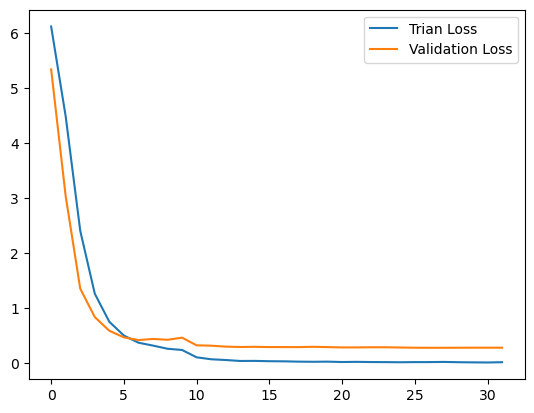

In [121]:
plt.plot(history.history["loss"], label = "Trian Loss") # train hataları ve validation hatalarını her epoch için çizdiriyoruz
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

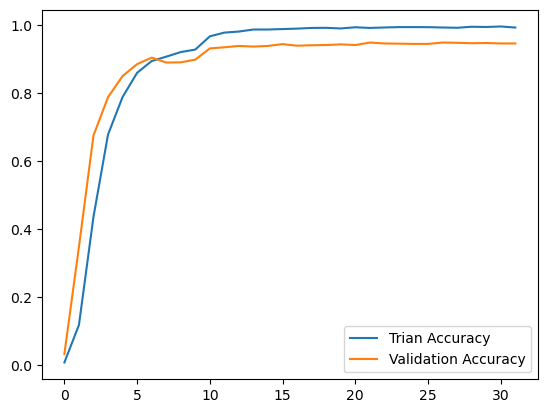

In [122]:
plt.figure()#train acurracy ve validation acurracy her epoch için çizdiriyoruz
plt.plot(history.history["accuracy"], label = "Trian Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [123]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = 32)

48/48 [==============================] - 1s 8ms/step - loss: 0.2868 - accuracy: 0.9491


In [124]:
print('Test Loss : ', loss )
print('Test Acurracy : ', accuracy)

Test Loss :  0.28684118390083313
Test Acurracy :  0.9491077065467834


In [125]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis = 1)

48/48 [==============================] - 1s 8ms/step


In [126]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_train = np.argmax(y_train, axis = 1)

190/190 [==============================] - 2s 8ms/step


In [127]:
print(classification_report(y_train, y_train_pred, target_names = le.classes_))

                           precision    recall  f1-score   support

                    Dalag       1.00      1.00      1.00        13
                     Itom       1.00      1.00      1.00        14
                    Kahil       1.00      1.00      1.00        17
                    Lubog       1.00      1.00      1.00        15
                   Lunhaw       1.00      1.00      1.00        18
            Maayong adlaw       1.00      1.00      1.00        15
            Maayong gabii       1.00      1.00      1.00        15
                 Ngitngit       1.00      1.00      1.00        16
                   Pastel       1.00      1.00      1.00        19
                   Pug-aw       1.00      1.00      1.00        18
                     Puti       1.00      1.00      1.00        16
                     Puwa       1.00      1.00      1.00        16
                  Tabonon       1.00      1.00      1.00        19
                    Tapol       1.00      1.00      1.00     

In [128]:
print(classification_report(y_test, y_pred))#, target_names = le.classes_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.80      0.67      0.73         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         5
           6       0.80      0.80      0.80         5
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       0.50      1.00      0.67         1
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17       0.80    

C:\Users\mstbl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mstbl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mstbl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
